# AlexNet

## Imports

In [25]:
import os
import torch
import torchvision
from AlexNet import AleXNet
import matplotlib.pyplot as plt

from train import train_model
from eval import set_seed, compute_confusion_matrix
from plot import plot_training_loss, plot_accuracy, plot_confusion_matrix
from dataset_loader import get_dataloaders_cifar10, unNormalize

## Initialize Setting

In [26]:
RANDOM_SEED = 123
BATCH_SIZE  = 256
NUM_EPCOHS  = 200

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

set_seed(RANDOM_SEED)

## Applying Transforms to the Dataset

In [27]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms  = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2
)

for images, labels in train_loader:
    print('Image batch dimensions: ', images.shape)
    print('Image label dimensions: ', labels.shape)
    print('Class labels of 10 examples: ', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions:  torch.Size([256, 3, 64, 64])
Image label dimensions:  torch.Size([256])
Class labels of 10 examples:  tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## Training

In [28]:
model = AleXNet(num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

mini_batch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPCOHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc'
)

Epoch: 001/200| Batch 0000/0175| Loss: 2.3021
Epoch: 001/200| Batch 0100/0175| Loss: 2.2837
Epoch: 001/200| Train: 20.25%| Validation: 20.66%
Time elapsed: 0.43 min
Epoch: 002/200| Batch 0000/0175| Loss: 1.9417
Epoch: 002/200| Batch 0100/0175| Loss: 1.9415
Epoch: 002/200| Train: 32.57%| Validation: 32.96%
Time elapsed: 0.84 min
Epoch: 003/200| Batch 0000/0175| Loss: 1.6955
Epoch: 003/200| Batch 0100/0175| Loss: 1.5434
Epoch: 003/200| Train: 46.64%| Validation: 47.04%
Time elapsed: 1.28 min
Epoch: 004/200| Batch 0000/0175| Loss: 1.3945
Epoch: 004/200| Batch 0100/0175| Loss: 1.5260
Epoch: 004/200| Train: 53.46%| Validation: 52.86%
Time elapsed: 1.72 min
Epoch: 005/200| Batch 0000/0175| Loss: 1.4022
Epoch: 005/200| Batch 0100/0175| Loss: 1.1775
Epoch: 005/200| Train: 59.13%| Validation: 58.72%
Time elapsed: 2.16 min
Epoch: 006/200| Batch 0000/0175| Loss: 1.2607
Epoch: 006/200| Batch 0100/0175| Loss: 1.2005
Epoch: 006/200| Train: 62.94%| Validation: 61.64%
Time elapsed: 2.59 min
Epoch: 007

In [29]:
os.makedirs('save_model', exist_ok=True)
torch.save(model.state_dict(), 'save_model/AlexNet.pt')

## Plots

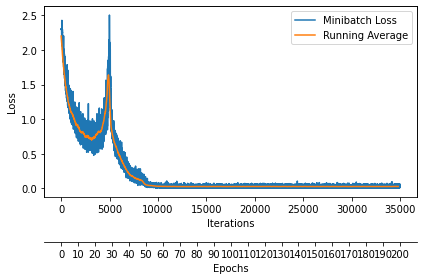

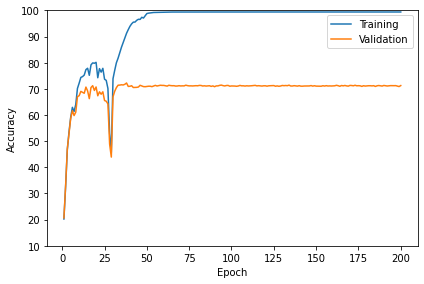

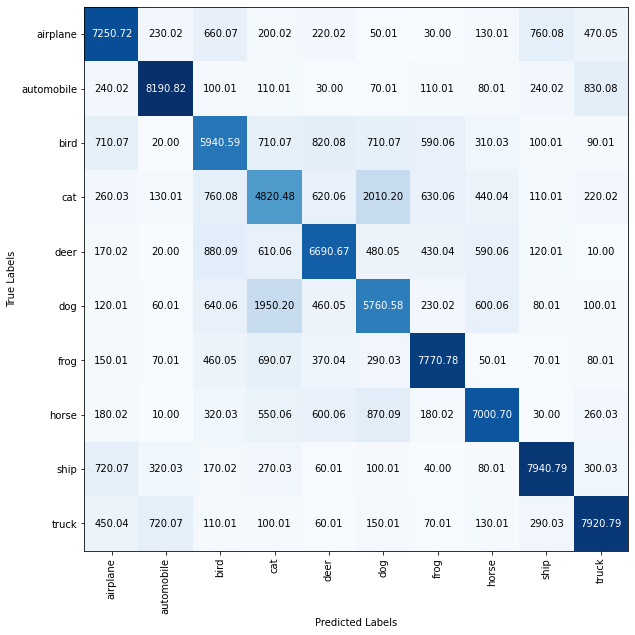

In [30]:
plot_training_loss(mini_batch_loss_list=mini_batch_loss_list,
                   num_epoch=NUM_EPCOHS,
                   iter_per_epoch=len(train_loader),
                   result_dir=None,
                   averaging_iteration=200
                   )

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None
)
plt.ylim([10, 100])
plt.show()

model.cpu()
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, figsize=(10, 10), show_absolute=True, class_names=class_dict.values())
plt.show()